# Determine fluxes for Toya MDVs using old LimitFlux2Core method

# Introduction

This notebook contains a description of the FluxModels module. This module contains classes for FBA, $^{13}$C MFA, and 2S-$^{13}$C MFA models, as well as for ELVA models. Each of this models has a corresponding results class: FBAResults, FVAResults, C13FVAResults, TSFVAResults, C13Results, TSResults, ELVAResults.

# Setup

First, we need to set the path and environment variable properly:

In [1]:
quantmodelDir = '/scratch/david.ando/published-jqmm/quantmodel'

This is the only place where the jQMM library path needs to be set.

In [2]:
%matplotlib inline

import sys, os
pythonPath = quantmodelDir+"/code/core"
if pythonPath not in sys.path:
    sys.path.append(pythonPath)
os.environ["QUANTMODELPATH"] = quantmodelDir

Then import the needed classes:

In [3]:
import FluxModels as FM
import enhancedLists, ReactionNetworks

And move to a scratch directory (to make things faster):

In [4]:
cd /scratch/david.ando/tests

/scratch/david.ando/tests


# Classes description

FluxModel represents the base class form which all other model classes are derived, but it is never used by itself. We will, hence, skip its description and demonstrate the classes that are actually used for flux calculations

## FBAModel, FBAresults and FVAresults

These classes are used for Flux Balance Analysis (FBA) and Flux Variability Analysis (FVA) calculations. For example: 

In [5]:
qmodeldir         = os.environ['QUANTMODELPATH']
basedir           = qmodeldir+'/data/tests/Toya2010/2S/'
testdir           = basedir + '2SpaperTest/'

FBAfileName = testdir+'XML/'+'EciJR904wt5hGrowthPartial.xml'    
FBAmodel    = FM.FBAModel(FBAfileName)

gets us an FBA model, and we can find fluxes by doing:

In [6]:
FBAresults  = FBAmodel.findFluxes()
fluxDictFBA = FBAresults.reactionNetwork.reactionList.getFluxDictionary()

In [7]:
print fluxDictFBA['PGI'].net

4.8848561646


In the same fashion, we can obtain the FVA results by doing:

In [8]:
FVAresults   = FBAmodel.FVA(['PDH','PGI','MDH'])
fluxDictFVA = FVAresults.reactionNetwork.reactionList.getReactionDictionary()

In [9]:
for name in ['PDH','PGI','MDH']:
    print name+": "+str(fluxDictFVA[name].flux.net)

PDH: [0:10.2006036871:18.6327817768]
PGI: [-6.98668484257:4.8848561646:11.5384750666]
MDH: [-8.28839116417:2.79597922572:29.2100898247]


One can use the **changeObjective** function to change the objective:

In [10]:
FBAmodel.changeObjective('BiomassEcoli',0)
FBAmodel.changeObjective('PDH',1)

In [11]:
FBAresults2 = FBAmodel.findFluxes()
fluxDictFBA2 = FBAresults2.reactionNetwork.reactionList.getFluxDictionary()

In [12]:
print fluxDictFBA['PDH'].net
print fluxDictFBA2['PDH'].net

10.2006036871
42.5


and the **printSuccess** method to print if the run was successful:

In [13]:
FBAresults.printSuccess(onlyFail=False)

lp successful


## C13Model, C13Results, C13FVAResults

These classes are used for $^{13}$C Metabolic Flux Analysis ($^{13}$C MFA) and $^{13}$C Flux variability Analysis ($^{13}$C FVA). 

For example, we can load the toy TCA cycle model:

In [14]:
qmodeldir         = os.environ['QUANTMODELPATH']    
dirDATA           = qmodeldir+'/data/tests/TCAtoy/' 

REACTIONSfilename   = dirDATA+'REACTIONStca.txt' 
FEEDfilename        = dirDATA+'FEEDtca.txt'
CEMSfilename        = dirDATA+'GCMStca.txt'
CEMSSTDfilename     = dirDATA+'GCMSerrtca.txt'
FLUXESFreefilename  = dirDATA+'FLUXtca.txt'

atomTransitions = enhancedLists.AtomTransitionList(REACTIONSfilename)
ReacNet = atomTransitions.getReactionNetwork('E. coli wt5h 13C MFA')

ReacNet.addLabeling(CEMSfilename,'LCMSLabelData',CEMSSTDfilename,minSTD=0.001)
ReacNet.addFeed(FEEDfilename)
ReacNet.loadFluxBounds(FLUXESFreefilename)

ReacNet.write('TCA.sbml') 

1

In [15]:
C13model = FM.C13Model('TCA.sbml')

And then calculate fluxes and use **findFluxesStds** to calculate fluxes and standard deviations through the monte carlo approach:

In [16]:
%%time
results    = C13model.findFluxesStds(Nrep=10, procString='proc', erase=True)

CPU times: user 908 ms, sys: 2.46 s, total: 3.37 s
Wall time: 7 s


**plotExpvsCompLabelFragment** and **plotExpvsCompLabelXvsY** provide alternative ways to see the fits: 

/usr/local/share/jupyteruser/.virtualenvs/jbeipython2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


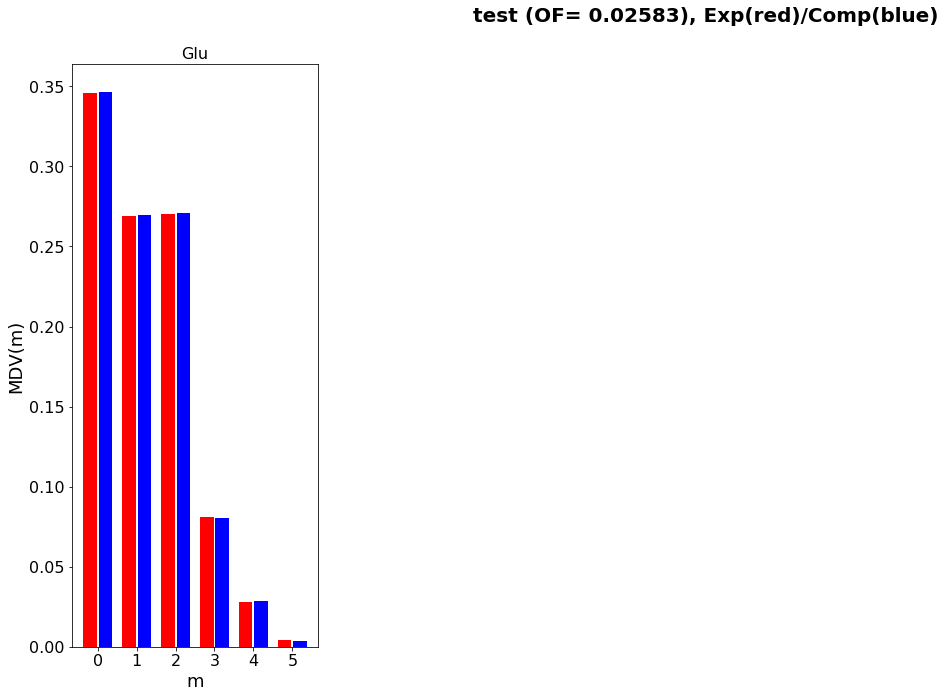

In [17]:
results.plotExpvsCompLabelFragment(titleFig='test')

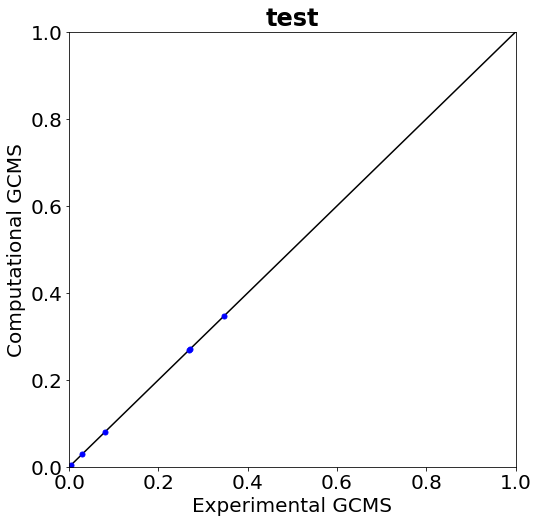

In [18]:
results.plotExpvsCompLabelXvsY(titleFig='test')

Results are stored in a reaction network where all ReactionNetworks methods are available:

In [19]:
results.reactionNetwork.reactionList.printFluxes(brief="False")

co2Out: 	150.0
r6: 	125.0
r1: 	100.0
r2: 	100.0
r7: 	75.0
r4: 	50.0
r5: 	50.0
r3: 	50.0
r8: 	50.0


In [20]:
results.EMUlabel['Glu']

array([ 0.34635,  0.26953,  0.27083,  0.08073,  0.02865,  0.00391])

In [21]:
results.fragDict['Glu'].mdv

array([ 0.346,  0.269,  0.27 ,  0.081,  0.028,  0.004])

A more detailed demonstration of these classes can be found in notebooks B2 and B3.

## TwoSC13Model, TSResults, TSFVAResults

These are the classes used for two-scale $^{13}$C Metabolic Flux Analysis (2S-$^{13}$C MFA).

Here, we offer a quick demonstration using the data from Toya *et al*. 2007. Notebook B4 offers a more complete demonstrating by regenerating all figures from Garcia Martin *et al*. 2015. Let's start by getting the input data from several files and blend them into a single sbml file:


In [22]:
datadir = os.environ['QUANTMODELPATH']+'/data/tests/Toya2010/2S/wt5h/'
strain ='wt5h'

BASEfilename      = datadir + 'EciJR904TKs.xml'
FLUXESfilename    = datadir + 'FLUX'+strain+'.txt'
REACTIONSfilename = datadir + 'REACTIONS'+strain+'.txt'      
MSfilename        = datadir + 'GCMS'+strain+'.txt'
FEEDfilename      = datadir + 'FEED'+strain+'.txt'
MSSTDfilename     = datadir + 'GCMSerr'+strain+'.txt'

In [23]:
# Load initial SBML file
reacNet = ReactionNetworks.TSReactionNetwork(BASEfilename)
    
# Add Measured fluxes
reacNet.loadFluxBounds(FLUXESfilename)
# Add carbon transitions
reacNet.addTransitions(REACTIONSfilename)
# Add measured labeling information
reacNet.addLabeling(MSfilename,'LCMSLabelData',MSSTDfilename,minSTD=0.001)
# Add feed labeling information
reacNet.addFeed(FEEDfilename)

# Limit fluxes to 500       
reacNet.capFluxBounds(500)

# Creates sbml file to create the model. All files in the library can be represented by a file name or
#a tuple of the type: (fileName, string of contents)
SBMLfile = ('temp.xml',reacNet.write('toString'))

and then use the file to create the two-scale model:

In [24]:
TSmodel  = FM.TwoSC13Model(('temp.xml',reacNet.write('toString'))) 

We can then use the **findFluxesRanges** method to fit fluxes and find the ranges compatible with labeling data:

In [25]:
fluxNames = TSmodel.reactionNetwork.C13ReacNet.reactionList.getReactionNameList(level=1)
TSresult = TSmodel.findFluxesRanges(Nrep=300,fluxNames=fluxNames,procString='proc',limitFlux2Core=True) 

And see the fits with the **plotExpvsCompLabelFragment** method:

CPU times: user 2.74 s, sys: 5.21 s, total: 7.94 s
Wall time: 913 ms


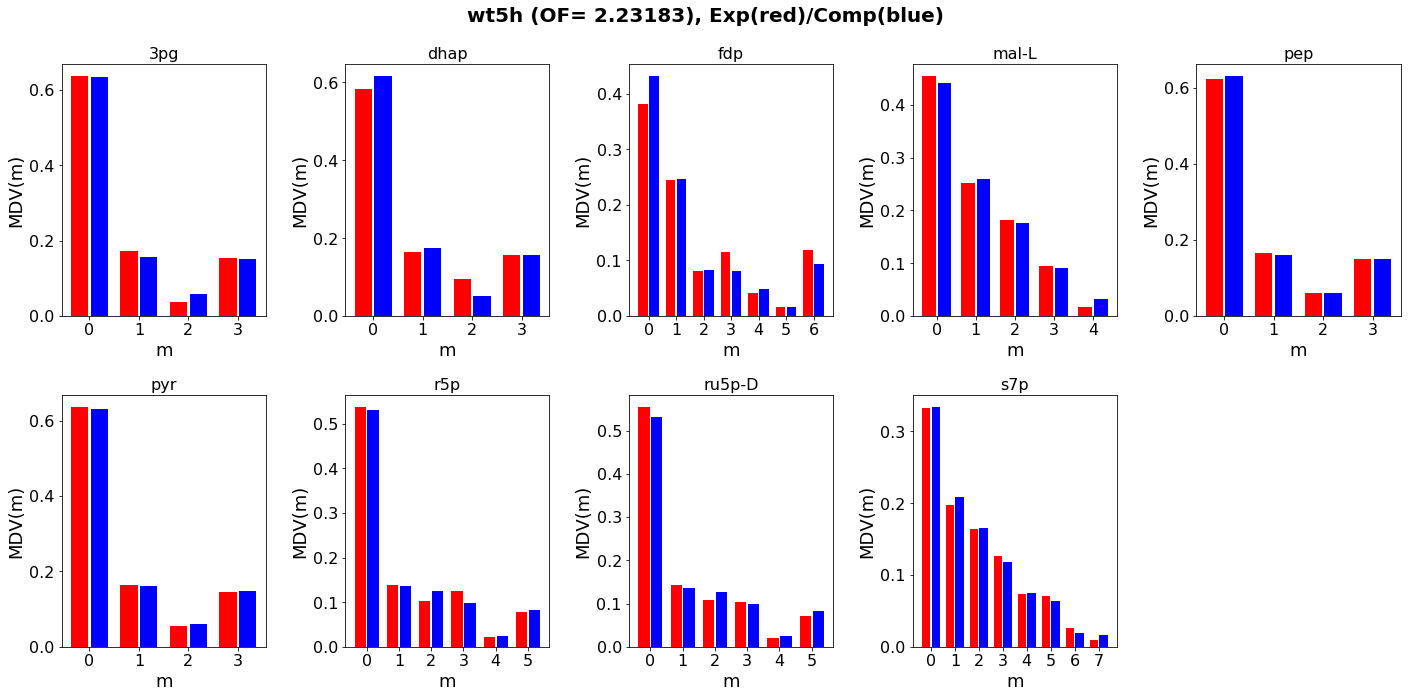

In [26]:
%%time
TSresult.plotExpvsCompLabelFragment(titleFig='wt5h')

In [27]:
TSresult.reactionNetwork.reactionList.printFluxes(brief="False")

ADK1: 	500.0
ADNt2r: 	-500.0
ADNt2: 	500.0
URAt2: 	500.0
URAt2r: 	-500.0
ADK3: 	-498.04825832
NDPK1: 	-489.964712584
ATPS4r: 	61.043481363
CYTBO3: 	48.7706682165
H2Ot: 	-43.8140702528
EX_h2o_e_: 	43.8140702528
NADH6: 	43.2627466634
CO2t: 	-26.0397076737
EX_co2_e_: 	26.0397076737
O2t: 	24.3853341083
EX_o2_e_: 	-24.3853341083
PGK: 	-20.0398273513
GAPD: 	20.0398273513
PGM: 	-18.9252394413
ENO: 	18.9252394413
GLUDy: 	-14.3617047457
FUM: 	13.5679035888
MDH: 	13.4465304039
PDH: 	12.8443311122
EX_h_e_: 	12.3121388581
EX_glc_e_: 	-11.7
GLCpts: 	11.7
PPC: 	10.7790755051
THD2: 	10.2951884861
ASPTA: 	-10.0366768357
FBA: 	9.82102452125
PFK: 	9.82102452125
TPI: 	9.68173732125
NH4t: 	8.93782429
EX_nh4_e_: 	-8.93782429
PGI: 	8.59703060375
PPCK: 	7.87768980113
ADSS: 	7.65902646569
ADSL1r: 	7.65902646569
ATPM: 	7.6
INSK: 	7.41874229569
ADA: 	7.41486896235
NTD7: 	7.41293229569
ACONT: 	6.31123927219
CS: 	6.31123927219
ICDHyr: 	6.31122757219
AKGDH: 	5.38942957219
SUCD1i: 	5.24412265312
SUCD4: 	5.244122653

UAG2Ei: 	0.0
PROD2: 	0.0
FUMt2_2: 	0.0
FUMt2_3: 	0.0
EX_tre_e_: 	0.0
EX_arab_L_e_: 	0.0
DMSOR2e: 	0.0
CHRPL: 	0.0
GSNK: 	0.0
NAt3_2: 	0.0
EX_ura_e_: 	0.0
EX_mal_L_e_: 	0.0
EX_nmn_e_: 	0.0
GLYCDx: 	0.0
EX_indole_e_: 	0.0
CRNt7: 	0.0
MALTpts: 	0.0
OCDCAt2: 	0.0
NTD4: 	0.0
AP4AH: 	0.0
EX_but_e_: 	0.0
G6PDA: 	0.0
EX_maltpt_e_: 	0.0
EX_acmana_e_: 	0.0
GLUCYS: 	0.0
ETHAAL: 	0.0
MLTG5: 	0.0
LEUt2r: 	0.0
ACACCT: 	0.0
MLTG1: 	0.0
XYLK: 	0.0
MLTG2: 	0.0
DKGLCNR1: 	0.0
AMPN: 	0.0
NADH5: 	0.0
DXYLK: 	0.0
NADH8: 	0.0
NADH9: 	0.0
3HCINNMH: 	0.0
GLYCTO2: 	0.0
NAt3_15: 	0.0
TMAOR2e: 	0.0
GAMpts: 	0.0
GMAND: 	0.0
PTRCt2r: 	0.0
RBK: 	0.0
2DGLCNRx: 	0.0
2DGLCNRy: 	0.0
ADOCBLS: 	0.0
DDGALK: 	0.0
PDXPP: 	0.0
NTRIR2x: 	0.0
EX_gua_e_: 	0.0
SUCpts: 	0.0
MALTabc: 	0.0
MALt2_3: 	0.0
ACS: 	0.0
ALAR: 	0.0
ME1: 	0.0
AACPS5: 	0.0
EX_maltttr_e_: 	0.0
DCYTD: 	0.0
GLUDC: 	0.0
CYANST: 	0.0
EX_hdca_e_: 	0.0
NTD9: 	0.0
AP5AH: 	0.0
AMANK: 	0.0
NO2t2r: 	0.0
DMATT: 	0.0
ASPt2_2: 	0.0
ASPt2_3: 	0.0
HYXNt: 	0.0
FUCt: 	0.0
MMM